<h3>Name: Nguyen Van Hau<br><br>
    Student ID: 2111167
</h3>

# NLP Assignment: Sentiment Analysis - VLSP Dataset

## 1 Set up environment (for Kaggle)

In [3]:
#Setup Gdrive file download extention 
!pip install gdown
!pip install transformers
!pip install datasets
!pip install pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64",

In [4]:
!gdown --id 1FiQSFJSiRBO_J4rYfZ94peoMv3x-Dup3 # vlsp_sentiment_train.csv
!gdown --id 1uruxz2CcconYmJNgGr_qL6t5nUwfkaST # vlsp_sentiment_test.csv

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1FiQSFJSiRBO_J4rYfZ94peoMv3x-Dup3
To: /kaggle/working/vlsp_sentiment_train.csv
100%|█████████████████████████████████████████| 858k/858k [00:00<00:00, 117MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1uruxz2CcconYmJNgGr_qL6t5nUwfkaST
To: /kaggle/working/vlsp_sentiment_test.csv
100%|████████████████████████████████████████| 159k/159k [00:00<00:00, 88.7MB/s]


In [5]:
import numpy as np
import pandas as pd
from string import digits
from collections import Counter
from pyvi import ViTokenizer
%matplotlib inline

## 2 Implementation

In [6]:
data_train = pd.read_csv("vlsp_sentiment_train.csv", sep='\t')
data_train.columns = ['Class', 'Data']
data_test = pd.read_csv("vlsp_sentiment_test.csv", sep='\t')
data_test.columns = ['Class', 'Data']

In [7]:
print(data_train.shape)
print(data_test.shape)

(5100, 2)
(1050, 2)


In [8]:
train_labels = data_train.iloc[:, 0].values
train_reviews = data_train.iloc[:, 1].values

test_labels = data_test.iloc[:, 0].values
test_reviews = data_test.iloc[:, 1].values

In [9]:
def preprocessing(reviews):
    reviews_processed = []
    for review in reviews:
        review_cool_one = ''.join([char for char in review if char not in digits])
        reviews_processed.append(review_cool_one)
        
    word_reviews = []
    for review in reviews_processed:
        review = ViTokenizer.tokenize(review.lower())
        word_reviews.append(review)

    return word_reviews

In [10]:
train_reviews = preprocessing(train_reviews)
test_reviews = preprocessing(test_reviews)

train_reviews[0]

'mình đã dùng anywhere thế_hệ đầu , quả là đầy thất_vọng , hiện_tại đang vứt xó . giá thì đắt , ngốn pin như ăn_gỏi , nặng'

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
encoded_train_labels = le.fit_transform(train_labels)
encoded_test_labels = le.transform(test_labels)

In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

2025-04-23 10:39:04.955727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745404745.175545      54 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745404745.238687      54 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


cuda


In [13]:
model_name = "vinai/phobert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

def tokenize_function(examples):
    tokenized = tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=256,
        add_special_tokens=True
    )
    return {k: v for k, v in tokenized.items()}

# Create HuggingFace Dataset
train_dataset = Dataset.from_dict({"text": train_reviews, "labels": encoded_train_labels})
train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

Map:   0%|          | 0/5100 [00:00<?, ? examples/s]

In [14]:
test_dataset = Dataset.from_dict({"text": test_reviews, "labels": encoded_test_labels})
test_dataset = test_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

Map:   0%|          | 0/1050 [00:00<?, ? examples/s]

In [17]:
print("Train dataset features:", train_dataset.features)
print("Sample item:", train_dataset[0])

Train dataset features: {'labels': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Sample item: {'labels': 0, 'input_ids': [0, 68, 14, 175, 18909, 17760, 8535, 1190, 127, 4, 645, 8, 545, 2804, 4, 874, 52, 4636, 29871, 5, 133, 54, 2239, 4, 15413, 2179, 42, 7265, 12889, 4, 534, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [18]:
num_labels=len(np.unique(encoded_train_labels))
num_labels

3

In [19]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    ignore_mismatched_sizes=True
).to(device)

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [20]:
training_args = TrainingArguments(
    output_dir="./phobert-sentiment",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="./logs",
    logging_steps=100,
    report_to="none",
    gradient_accumulation_steps=2,
    warmup_ratio=0.1,
    fp16=torch.cuda.is_available(),
)

In [21]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": (predictions == labels).mean(),
        "detailed": classification_report(labels, predictions, output_dict=True)
    }

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: {'accuracy': (p.predictions.argmax(-1) == p.label_ids).mean()},
)

In [23]:
try:
    trainer.train()
    results = trainer.evaluate()
    print("Final results:", results)
except Exception as e:
    print("Error during training:", e)
    print("Debugging info:")
    print("Sample input_ids:", train_dataset[0]['input_ids'])
    print("Sample attention_mask:", train_dataset[0]['attention_mask'])
    print("Sample label:", train_dataset[0]['labels'])

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.044520,0.494286
2,1.078100,0.783324,0.666667
3,0.836000,0.687671,0.719048
4,0.672900,0.661442,0.715238
5,0.609500,0.643172,0.726667
6,0.609500,0.638588,0.724762
7,0.553300,0.633234,0.731429
8,0.526600,0.641430,0.729524
9,0.482800,0.646392,0.729524
10,0.468000,0.645096,0.730476


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

Final results: {'eval_loss': 0.6332340836524963, 'eval_accuracy': 0.7314285714285714, 'eval_runtime': 9.0791, 'eval_samples_per_second': 115.65, 'eval_steps_per_second': 1.872, 'epoch': 10.0}


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Accuracy: 0.7314

--- Averaged Metrics ---
Precision (Macro): 0.7329
Recall (Macro):    0.7314
F1-score (Macro):  0.7314
--------------------
Precision (Weighted): 0.7329
Recall (Weighted):    0.7314
F1-score (Weighted):  0.7314
--------------------

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       350
           1       0.64      0.66      0.65       350
           2       0.79      0.83      0.81       350

    accuracy                           0.73      1050
   macro avg       0.73      0.73      0.73      1050
weighted avg       0.73      0.73      0.73      1050


--- Confusion Matrix ---
[[247  81  22]
 [ 61 232  57]
 [ 11  50 289]]


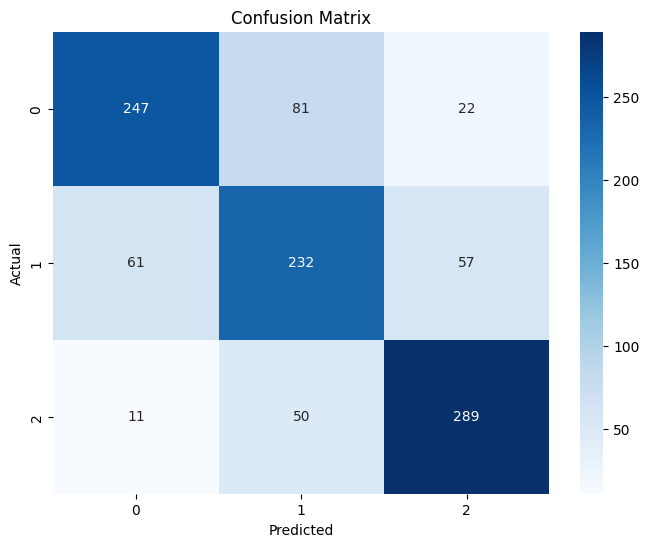

In [25]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns 
import matplotlib.pyplot as plt 


predictions_output = trainer.predict(test_dataset)

logits = predictions_output.predictions
y_true = predictions_output.label_ids
y_pred = np.argmax(logits, axis=-1)


accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# 5. Precision, Recall, F1-score (Micro, Macro, Weighted Averages)
# 'macro': Calculate metrics for each label, and find their unweighted mean. Treats all classes equally.
# 'weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). Accounts for class imbalance.
# 'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives. Good overall measure.
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(y_true, y_pred, average='micro') # Note: Micro P, R, F1 are all equal to accuracy for multi-class

print("\n--- Averaged Metrics ---")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Recall (Macro):    {recall_macro:.4f}")
print(f"F1-score (Macro):  {f1_macro:.4f}")
print("-" * 20)
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Weighted):    {recall_weighted:.4f}")
print(f"F1-score (Weighted):  {f1_weighted:.4f}")
print("-" * 20)
# Micro average is usually less informative for balanced datasets but included for completeness
# print(f"Precision (Micro): {precision_micro:.4f}")
# print(f"Recall (Micro):    {recall_micro:.4f}")
# print(f"F1-score (Micro):  {f1_micro:.4f}")


# 6. Classification Report (provides per-class metrics and averages)
print("\n--- Classification Report ---")
# You might need class names if you have them, otherwise it uses 0, 1, 2...
# target_names = ['class_0_name', 'class_1_name', 'class_2_name'] # Optional: Replace with your actual class names
# print(classification_report(y_true, y_pred, target_names=target_names))
print(classification_report(y_true, y_pred)) # Without specific names


# 7. Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Optional: Plot Confusion Matrix for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', # fmt='d' displays integers
            # xticklabels=target_names, yticklabels=target_names # Uncomment if you have target_names
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()